<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/code/01ZLMA_ex05_GLM_Model_Diagnostics_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 05

Exercise 05 of the course 01ZLMA.

# Model Diagnostics - Post-hoc analysis of glm

How to check if our GLM is sufficient and how to do it in R.


In [ ]:
library(tidyverse)
library(MASS)
library(knitr)

install.packages("GGally")
library(GGally)

install.packages("car")
library(car)


## Dataset trees

The volume y (in cubic feet) of 31 black cherry trees (střemcha pozdní) was measured as well as the height (in feet) and the girth, or diameter,
at breast height (in inches). The volume of the tree is related to the volume of timber, which is important economically.


More information can be find in
Chapter 8: Generalized Linear Models: Diagnostics (Peter K. Dunn and Gordon K. Smyth, Generalized Linear Models With Examples in R)

In [ ]:
data(trees)

In [ ]:
head(trees)
summary(trees)

In [ ]:
ggpairs(trees)

The relationships between the tree volume and height, and tree volume and girth, both appear non-linear.

In [ ]:
log_trees <- trees %>%
 mutate(log_Girth = log(Girth),
        log_Height = log(Height),
        log_Volume = log(Volume))
ggpairs(log_trees)

In [ ]:
trans_trees <- trees %>%
 mutate(cone = (pi*(Girth/12)^2*Height)/12,
        cylinder = (pi*(Girth/12)^2*Height)/4)
ggpairs(trans_trees)

## Classical Regression analysis approach

How we did it last term ...

### Model 0 lm()

In [ ]:
### Model 0 (_m0)

In [ ]:
trees_m0a <- lm( log(Volume)~log(Girth)+log(Height), data=trees)
summary(trees_m0a)

If we understand given problem, we can find good linear relation with some advanced transformation of independent varialbes.

In [ ]:
trees_m0b <- lm( Volume~ -1+ cone, data=trans_trees)
summary(trees_m0b)
trees_m0c <- lm( Volume~ -1 +cylinder, data=trans_trees)
summary(trees_m0c)

## GLM approach


Since response is continuous nonnegative variable, we use `family = gamma`. In the first approach we try canonical link function, which is for gamma distribution: $g(\mu) = 1/\mu$.

### Model 1 (_m1)

In [ ]:
trees_m1 <- glm( Volume ~ Girth + Height, data=trees, family=Gamma)
summary(trees_m1)
#printCoefmat(coef(summary(trees_m1)))

### Questions:

* What can you say from the `summary()` about the model 0?
* Do you understand to all numbers and do you know how they were computed?

### Tasks

* Compute different types of residuals.
* Plot residuals vs. fitted values or regressors
* Validate used ling function with working responses.
* Validate used regressors with Component+Residual, ie Partial Residual Plots

## Residuals

Consider  the GLM from for the observations $Y_1,\ldots,Y_n$ and assume $a_i(\phi) = a_i \phi$, where $a_i>0$ are known for $i=1,\ldots, n$.



From estimation of GLMs as Locally Like Linear Regression by using IRLS we can obtain weights $W$ with  *working responses* and compute *working residuals*.

**Working residuals**
$$e_i = z_i − \hat{\eta_i}$$

**Pearson residuals**

$$ {r_{i}^{P}
=\frac{y_{i}-\hat{\mu}_{i}}{\sqrt{a_i\, v(\hat\mu_i)}}},\qquad
v(\mu_i)= b^{\prime\prime}(\theta_i) \mbox{ for } \theta_i = \theta(\mu_i),
$$

where $v(\mu_i)$ is called a variance function and $V[Y_i] = a_i \phi v(\mu_i)$.
The Pearson residual is the response residual scaled with with the estimated standard deviation for the observation.


**Pearson standartized residuals**

$$
{r_{i}^{PS}
=}\frac{y_{i}-\hat{\mu}_{i}}{\sqrt{\hat{V}[Y_{i}](1-h_{ii})}}
=\frac{y_{i}-\hat{\mu}_{i}}{\sqrt{a_i \hat\phi \, v(\hat\mu_i)(1-h_{ii})}}
={\frac{r_{i}^{P}}{\sqrt{\hat\phi(1-h_{ii})}}},
$$

**Anscombe residuals**

For models, where $a_i(\phi)=1$
$$
{r_{i}^{A}=\frac{A(y_{i})-A(\hat{\mu}_{i})}{\sqrt{\hat{V}[A(y_{i})]}}},\quad i=1,...,n
$$
where
$$
A(y)=\int_{-\infty}^{y}\frac{d\mu}{v^{1/3}(\mu)}.
$$

**Deviance residual**

The deviance residual for the i’th observation is defined as

$$
{r_{i}^{D}=\mbox{sign} (y_{i}-\hat{\mu}_{i})\sqrt{D_{i}}},\quad i=1,...,n,
$$
where
$$
D=\sum_{i=1}^{n}(r_{i}^{D})^{2} = \sum_{i=1}^{n}D_{i}=
\sum_{i=1}^{n}\frac{2}{a_{i}}\left[y_{i}(\tilde{\theta}_{i}-
\hat{\theta}_{i})-\left(b(\tilde{\theta}_{i})-b(\hat{\theta}_{i})\right)\right].
$$


**Deviance standartized residual**
$$
{r_{i}^{DS}=\frac{r_{i}^{D}}{\sqrt{\hat\phi(1-h_{ii})}}},\quad i=1,...,n,
$$

The deviance residuals are the generalization of the residuals from the classical linear model. They are constructed using the analogy between the deviance and the RSS.

##Type of residuals in R for a fitted glm() `model`:

• Pearson residuals $r^P$ : `resid(model, type="pearson")`.

• Deviance residuals $r^D$ (default): `resid(model)`

• Quantile residuals $r^Q$ from package `library(statmod)`: `qresid(model)`

• Partial residuals $u_j$ : `resid(model, type="partial")`.

• Working residuals $e$: `resid(model, type="working")`.

• Response residuals $(y − \hat{\mu})$: `resid(model, type="response")`.

• Standardized deviance residuals $r^{DS}$: `rstandard(model)`.

• Studentized deviance residuals $r^{DStud}$: `rstudent(model)`.


Gamma model is necessarily heteroskedastic, because the variance is  proportional to $μ^2$.

In [ ]:
# Residuals
expected  <- trees_m1$y
estimates <- trees_m1$fitted.values
v         <- estimates^2 # for gamma distribution used in our model with trees dataset
# If we have Poisson distribution: v = estimates,
# If Bernouli: v = estiamtes(1-estimates), ...

In [ ]:
# Response residuals
r_response1 <- residuals(trees_m1, type="response")
r_response2 <- (expected - estimates)
head(cbind(r_response1,r_response2))


In [ ]:
# Working residuals
r_working1 <- residuals(trees_m1, type="working")
r_working2 <- (expected - estimates) / v
r_working3 <- trees_m1$residuals
head(cbind(r_working1,r_working2,r_working3))


In [ ]:
# Pearson residuals
r_pearson1 <- residuals(trees_m1, type="pearson") # Pearson residuals from resid() function
r_pearson2 <- (expected - estimates) / sqrt(v)    # Pearson residuals from above definitionf for gamma
head(cbind(r_pearson1,r_pearson2))


In [ ]:
# Pearson standartized residuals
r_pearson_std1 <- rstandard(trees_m1, type = "pearson")

# compute estimation of dispersion parametr phi by hand and from summary function
w <- weights(trees_m1, type="working")
e <- residuals(trees_m1, type="working")
phi_est_hand <- sum(w * e^2) /df.residual(trees_m1)
phi_est <- summary(trees_m1)$dispersion # Pearsons estiamtes of phi
cbind(phi_est_hand, phi_est)
# Pearson standartized residuals by hand
r_pearson_std2 <- r_pearson2 / sqrt(phi_est*(1 - hatvalues(trees_m1)) )
head(cbind(r_pearson_std1,r_pearson_std2))


In [ ]:
# Deviance residuals
r_deviance <- resid(trees_m1 )
r_deviance_std <- rstandard(trees_m1) # Standart
head(cbind(r_deviance,r_deviance_std))
? rstandard

In [ ]:
trees_modeled <- trees %>%
  mutate(fitted = trees_m1$fitted.values,
         r_deviance_std =rstandard(trees_m1, type = "deviance"),
         r_pearson_std = rstandard(trees_m1, type = "pearson") )
head(trees_modeled)

In [ ]:
library(ggplot2)
install.packages("gridExtra")
library(gridExtra)

p <- ggplot(trees_modeled, aes(x = Volume,y = fitted)) +
      geom_smooth()+
      geom_point() +
      geom_abline(intercept = 0, slope = 1)
p

Plots of the residuals against the fitted values $\mu$ and the residuals against
$x_j$ are the main tools for diagnostic analysis. Using deviance residuals is preferred in these plots because they have approximately constant variance.

In [ ]:
par(mfrow=c(2,3))
p1<-ggplot(trees_modeled, aes(x = fitted, y = r_deviance_std)) +
  geom_smooth() +
  geom_point() +
  labs(x = "Fitted values",
       y = "Deviance standartized residuals")
p2<-ggplot(trees_modeled, aes(x = Girth, y = r_deviance_std)) +
  geom_smooth() +
  geom_point() +
  labs(y = "Deviance standartized residuals")
p3<-ggplot(trees_modeled, aes(x = Height, y = r_deviance_std)) +
  geom_smooth() +
  geom_point() +
  labs(y = "Deviance standartized residuals")
grid.arrange(p1, p2, p3, ncol = 3)


If the evidence shows problems with the systematic component, then the
cause may be an incorrect link function, or an incorrect linear predictor (for
example, important explanatory variables are missing, or covariates should
be transformed), or both.

*Working responses* $z_i = \hat\eta_i + g^\prime(\hat\mu_i) (y_i-\hat\mu_i)$
 can be determined from working residuals, obtained by the function `resid(model, type="working")`.

 We plot Working responses against predicted values of linear predictor $\hat\eta_i$.


In [ ]:
eta <- trees_m1$linear.predictor
z  <- resid(trees_m1, type="working") + eta
plot( z ~ eta, las=1,
        xlab="Linear predictor, eta", ylab="Working responses, z")
abline(0, 1, col="grey")

To determine if covariate $x_j$ is included on the incorrect scale, use partial
residuals
$$ u_j = e_i + \hat{\beta}_j x_j.$$
In R use function `resid(fit, type="partial")`.

Component+Residual (Partial Residual plot, ie. $x_j$ against $j$th partial residuals) can be plotted by function `termplot()` or `crPlots()` from the library `cars`

In [ ]:
trees_modeled <- trees_modeled %>%
mutate(Partial_for_Girth = as.data.frame(resid(trees_m1, type="partial"))$Girth,
        Partial_for_Height = as.data.frame(resid(trees_m1, type="partial"))$Height)
summary(trees_modeled)

In [ ]:
ggplot(trees_modeled, aes(x = Girth, y = Partial_for_Girth)) +
  geom_smooth(method = lm) +
  geom_point() +
  labs(y = "Partial for Girth",
       x = "Girth")

 ggplot(trees_modeled, aes(x = Height, y = Partial_for_Height)) +
  geom_smooth(method = lm) +
  geom_point() +
  labs(y = "Partial for Height",
       x = "Height")

In [ ]:
termplot(trees_m1, partial.resid=TRUE, las=1)
?termplot


In [ ]:
#install.packages("car")
#library(car)
#? crPlot

In [ ]:
crPlots(trees_m1)

Link function is not choose correctly. Try another link function.

### Model 2 (_m2)

Let's try gamma distribution with link function $g(\mu)=\log \mu$.

In [ ]:
trees_m2 <- update(trees_m1, family=Gamma(link="log"))
summary(trees_m2)
#printCoefmat(coef(summary(trees_m2)))


Similar plots and analysis we did with model 01.

In [ ]:
trees_modeled<- trees_modeled %>%
  mutate(fitted2 = trees_m2$fitted.values,
         r_deviance_std2 =rstandard(trees_m2, type = "deviance"),
         r_pearson_std2= rstandard(trees_m2, type = "pearson") )
head(trees_modeled)

In [ ]:
par(mfrow=c(2,3))
p1<-ggplot(trees_modeled, aes(x = fitted, y = r_deviance_std2)) +
  geom_smooth() +
  geom_point() +
  labs(x = "Fitted values",
       y = "Deviance standartized residuals")
p2<-ggplot(trees_modeled, aes(x = Girth, y = r_deviance_std2)) +
  geom_smooth() +
  geom_point() +
  labs(y = "Deviance standartized residuals")
p3<-ggplot(trees_modeled, aes(x = Height, y = r_deviance_std2)) +
  geom_smooth() +
  geom_point() +
  labs(y = "Deviance standartized residuals")
grid.arrange(p1, p2, p3, ncol = 3)

In [ ]:
par(mfrow=c(1,3))
eta <-trees_m2$linear.predictor
z <- resid(trees_m2, type="working") + eta
plot( z ~ eta, las=1, las=1,
        xlab="Linear predictor, eta", ylab="Working residuals, z")
abline(0, 1, col="grey")
termplot(trees_m2, partial.resid=TRUE, las=1)

In [ ]:
crPlots(trees_m2)

We have correct link function, but we still have  problems with  systematic component and residual plots. Lets try some transformations of covariates.

### Model 3 (_m3)

We use log transformation of both $x_j$'s.

In [ ]:
trees_m3 <- glm( Volume ~ log(Girth) + log(Height),
                    family=Gamma(link=log), data=trees)
#summary(trees_m3)
printCoefmat(coef(summary(trees_m3)))

All covariates are significant in the model.



In [ ]:
par(mfrow=c(2,3))

scatter.smooth( rstandard(trees_m3) ~ fitted(trees_m3), las=1,
                  ylab="Standardized deviance residual", xlab="Fitted values" )
scatter.smooth( rstandard(trees_m3) ~ log(trees$Girth), las=1,
                  ylab="Standardized deviance residual", xlab="log(Girth)" )
scatter.smooth( rstandard(trees_m3) ~ log(trees$Height), las=1,
                  ylab="Standardized deviance residual", xlab="log(Height)" )

z <- resid(trees_m3, type="working") +trees_m3$linear.predictor
plot( z ~trees_m3$linear.predictor, las=1,
        xlab="Working responses, z", ylab="Linear predictor")
abline(0, 1) # Adds line of equality

termplot(trees_m3, partial.resid=TRUE, las=1)

Model 3 is sufficient :-)

Lets check AIC statistics for all three models.

In [ ]:
AIC <- c(trees_m1$aic,trees_m2$aic,trees_m3$aic)
names(AIC) <- c("AIC.1", "AIC.2", "AIC.3")
AIC

### Question:

* Why  we chose log transformation?
* Are residuals from the model 3 normal?

In [ ]:
# Deviance residauls
qqnorm(r_deviance_std, las=1 )
qqline(r_deviance_std)
# Deviance residauls
qqnorm(r_pearson_std2, las=1 )
qqline(r_pearson_std2)


In [ ]:
install.packages('surveillance')
library(surveillance)
r_anscombe <- anscombe.residuals(trees_m3, summary(trees_m1)$dispersion)
qqnorm(r_anscombe, las=1 )
qqline(r_anscombe)


Check normality with test

In [ ]:
install.packages("nortest")
library(nortest)
lillie.test(r_anscombe)
shapiro.test(r_anscombe)

lillie.test(r_deviance_std)
shapiro.test(r_deviance_std)

## Influence  Measures

Measures of influence can be computed using the same R functions
as for linear regression models:

• Cook’s distance D: `cooks.distance(model)`.

• dfbetas:  `dfbetas(model)`.

• dffits: `dffits(model)`.

• Covariance ratio cr: `covratio(model)`.

All these measures of influence, together with the leverages $h$, are returned using `influence.measures(model)`.

**Cook distance**

Let $\hat\beta_{(-i)}$ denotes estimation of $\beta$ computed without observation  $i$. Cook distance for $i$th observation is defined by
$$CD_i = \frac{1}{p} \left(\hat\beta - \hat\beta_{(-i)}\right)^T X^T W^{-1} X \left(\hat\beta - \hat\beta_{(-i)}\right)$$
but its computed by
$$
CD_i = \frac{1}{p} \left( r_i^{PS}\right)^2 \frac{h_{ii}}{1-h_{ii}}
$$
and observation is influence if
$$
CD_i \ > \ \frac{8}{n-2p}
$$

In [ ]:
par(mfrow=c(1,2))
cd <- cooks.distance(trees_m3)
plot( cd, col="red", cex=1.0, lwd=2, ylab="Cook's distance", las=1, ylim = c(-0.1,0.3))
abline(h = (8/(31-4)))
lev <- hatvalues(trees_m3)
plot( lev, col="red", cex=1.0, lwd=2, ylab="Leverage", las=1, ylim = c(-0.1,0.3))

In [ ]:
infl <- which.max(cd)
infl
cd[infl]

In [ ]:
cooks.distance(trees_m3)

In [ ]:
par(mfrow=c(2,2))
plot(trees_m3)

Let's try to estimate coefficients in the model, where we omitt obesrvation with largest influence.

In [ ]:
trees_m3_infl <- update(trees_m3, subset=(-infl) )
coef(trees_m3_infl)
coef(trees_m3)

Let's do the same, but omit the first observation instead.

In [ ]:
trees_m3.omit1 <- update(trees_m3, subset=(-1) ) # Vynecháme pozorování 1
coef(trees_m3.omit1)
coef(trees_m3)

A negligible change again

**Function `influence.measures()`.**

We know it from `lm()` and the usage is very similar. It obtain Cooks distance (`cook.d`) and diagonal elemtns of hat matrix (`hat`) and other influence measures.

In [ ]:
? influence.measures
influence.measures(trees_m3)

In [ ]:
im <- influence.measures(trees_m3)
names(im)

im$infmat <- round(im$infmat, 3 )
 head( im$infmat )

In [ ]:
#Compare cooks distances from im and directly from the function cooks.distance()
colSums( im$is.inf )
signif(cooks.distance(trees_m3), 1)
im$infmat[,"cook.d"]

No suspicious outliers or leverage points.

Another tools

In [ ]:
install.packages("boot")
library(boot)
glm.diag.plots(trees_m3, glmdiag = glm.diag(trees_m3), iden = TRUE)

## Predictions from final model


In [ ]:
par(mfrow=c(1,2))
plot(trees$Volume ~ trees$Girth, col="red", cex=0.9, lwd=1.5,
     xlab = "Girth", ylab="Volume", las=1)
legend("topleft", inset = .05, legend = c("Data", "Model 3"),
       col = c(2,4), bty="n", lwd = 1.5, pch=c(1,NA), cex=0.9, lty=c(0,1))
lines(fitted(trees_m3) ~ trees$Girth, col="blue", type = "l", lwd=1.5)

trees_3 <- data.frame(trees, fitted(trees_m3))
trees_3 <- trees_3[order(trees_3$Height),]
plot(trees_3$Volume ~ trees_3$Height, col="red", cex=0.9, lwd=1.5,
     xlab = "Height", ylab="Volume", las=1)
legend("topleft", inset = .05, legend = c("Data", "Model 3"),
       col = c(2,4), bty="n", lwd = 1.5, pch=c(1,NA), cex=0.9, lty=c(0,1))
lines(trees_3$fitted.trees_m3. ~ trees_3$Height, col="blue", type = "l", lwd=1.5)

Figure from: https://link.springer.com/chapter/10.1007/978-1-4419-0118-7_8

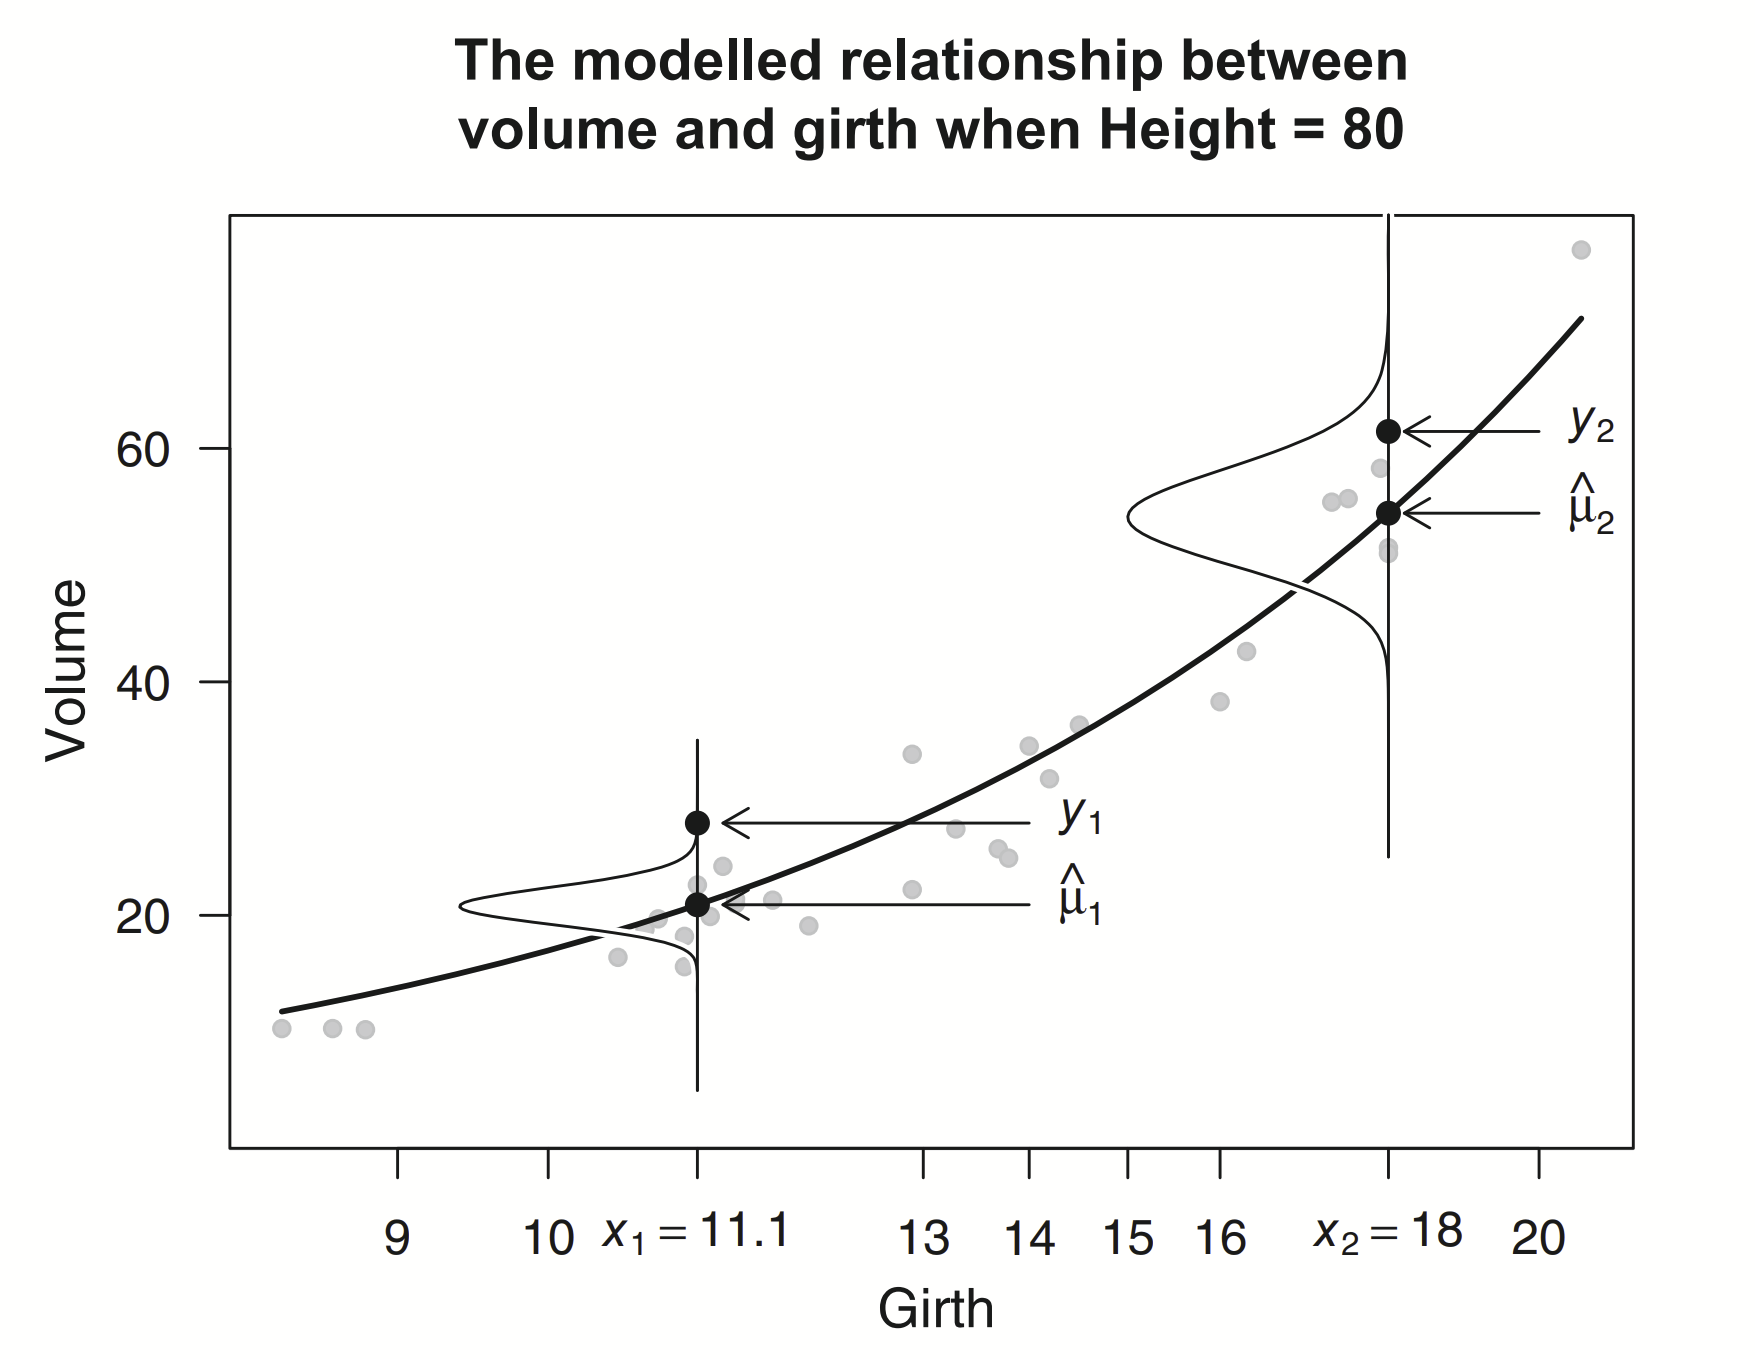







## Your Turn: HW 05

Problem 8.6. from the book:


The standardized deviance residual $r^{DS}$ is approximately the reduction
in the residual deviance when Observation $i$ is omitted from the data. Demonstrate this by R code using the $trees$ data as follows.

* Fit the model m_1 as

  `data(trees)`
   `model_full <- glm( Volume ~ log(Girth) + log(Height),family=Gamma(link=log), data=trees)`
 Compute the residual deviance, the Pearson estimate of $\phi$, and the standardized deviance residuals from this model.

* Omit Observation 1 from `trees`, and refit the model. Call this model
`model_omit_1`.

* Compute the difference between the residual deviance for the full model
`model_full` and for model `model_omit_1`. Show that this differences divided by the Pearson estimate of $\phi$ is approximately the standardized
deviance residuals squared.

* Repeat the above process for every observation $i$. At each iteration, call this model `model_omit_i`. Then, compute the difference between the deviance for the full model `model_full` and for model `model_omit_i`. Show that these differences divided by $\phi$ are approximately the standardized residuals squared.


# Additional Turn

## Analyse data of car accidents in Sweeden.

In [ ]:
sweden2 <- "https://raw.githubusercontent.com/francji1/01ZLMA/main/data/sweden.csv"
cars    <- read.table(sweden2, header = T, sep = ",")
summary(cars)
head(cars)



Dataset contains the number of deaths, he number of registered cars, the annual volume of sold fuels, the number of registered vehicles and the year. Our goal will be to create the best possible model for death rates. Since these are the number of events per unit time, we use the Poisson distribution with the *canonical link function*  $g (\mu) = log(\mu) $.

Because the observed period is relatively long and there have been significant changes in transport, we will only consider data from 1975.

In [ ]:
par(mfrow=c(1,2))
plot(cars$Deaths~cars$Year, col="red", lwd=2)
cars <- cars[cars$Year>1974,]
plot(cars$Deaths~cars$Year, col="red", lwd=2)

In [ ]:
attach(cars)

In [ ]:
ggpairs(cars)

# Tasks

* Find the best posssible model. Try add all varariables up to the second order interactions. You can use `step()` function based on `AIC`.
* Analyse residuals and check systematic components.
* If incorrect linear predictor appears, try to transform corresponding variable. Hint: `Fuel_transformed <- log(abs(Fuel-mean(Fuel)))`
* Run post hoc analysis of your final model again
* Find influence observations and decide how to cope with them (if any)
* Hide last 5 observations, train the model using remaining and try to predict response for the 5 hidden latest observations. Plot predictiions together with true observations.
